In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms

import datetime
from PIL import Image
import urllib.request as request

%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
data_path = 'data/'
cifar10_dataset = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Files already downloaded and verified


In [0]:
cifar10_validation = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Files already downloaded and verified


In [0]:
label_map = {1: 0, 3: 1}
class_names = ['car', 'cat']
data_set = [(img, label_map[label]) for img, label in cifar10_dataset if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in cifar10_validation if label in [1, 3]]

In [0]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [0]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


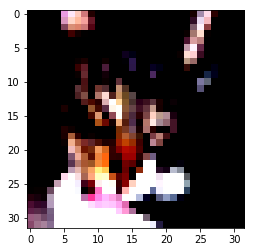

In [0]:
img, _ = data_set[100]
plt.imshow(img.permute(1, 2, 0), cmap='gray')

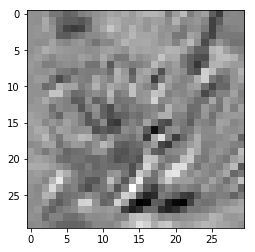

In [0]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

In [0]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

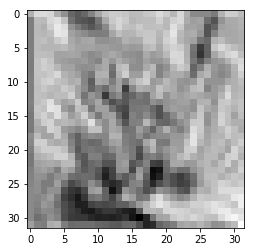

In [0]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
img.unsqueeze(0).shape, output.shape

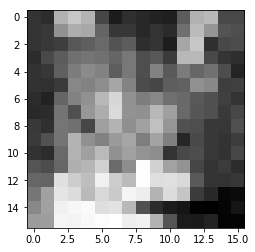

In [0]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')



In [0]:
model = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, padding=1),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Tanh(),
          nn.Conv2d(16, 8, kernel_size=3, padding=1),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Tanh(),
          nn.Linear(8 * 8 * 8, 32),
          nn.Tanh(),
          nn.Linear(32, 2)
        )

In [0]:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


In [0]:
img, _ = data_set[100]
model(img.unsqueeze(0))

RuntimeError: ignored

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [0]:
model = Net()
img, _ = data_set[100]
model(img.unsqueeze(0))

tensor([[ 0.1402, -0.0822]], grad_fn=<AddmmBackward>)

In [0]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

In [0]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.02)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, 
    optimizer=optimizer, 
    model=model, 
    loss_fn=loss_fn, 
    train_loader = train_loader
)


2019-05-27 21:46:02.480928 Epoch 1, Training loss 89.37909471988678
2019-05-27 21:46:53.516692 Epoch 10, Training loss 22.135397592559457
2019-05-27 21:47:50.129972 Epoch 20, Training loss 15.593500347808003
2019-05-27 21:48:47.742061 Epoch 30, Training loss 12.206716341897845
2019-05-27 21:49:44.666866 Epoch 40, Training loss 9.719878916628659
2019-05-27 21:50:42.346706 Epoch 50, Training loss 7.640749113634229
2019-05-27 21:51:38.596391 Epoch 60, Training loss 5.8935352973639965
2019-05-27 21:52:34.874723 Epoch 70, Training loss 4.488984267693013
2019-05-27 21:53:31.650251 Epoch 80, Training loss 3.523374842479825
2019-05-27 21:54:28.306200 Epoch 90, Training loss 2.6503089354373515
2019-05-27 21:55:26.406688 Epoch 100, Training loss 2.0322731975466013


In [0]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

for loader in [train_loader, val_loader]:
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in train_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # <1>
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    print("Accuracy: %f" % (correct / total))

Accuracy: 0.999200
Accuracy: 0.999200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: car


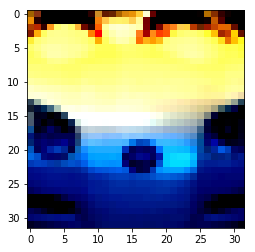

In [0]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)

model = Net()
out = model(img_t.unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))